# TD - Ensemble Learning

- Pensez à mesurer les temps d’apprentissage et d’inférence de chaque solution

### A. Base de données

##### La base de données « beer quality » comporte 1600 exemples décrits par 11 caractéristiques quantitatives. L’objectif est d’évaluer, sachant ces variables, la qualité d’une bière, évaluée de 1 (sans commentaire !) à 10 (particulièrement excellente). 

Charger la base et la séparer en deux : la matrice X des observations et le vecteur y des labels. Analyser rapidement les variables prédictives X et la variable à prédire y (quality).

Diviser la base de données en deux sous-ensembles d’apprentissage et de test (70/30).


In [1]:
#imports
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense

In [3]:
df_beer = pd.DataFrame(pd.read_excel("C:/Users/sarah/OneDrive/Bureau/TP_Ensemble_Learning/beer_quality.xlsx"))
#df_beer = pd.read_csv('C:/Users/sarah/OneDrive/Bureau/5A/Machine Learning Avancé/TP_Ensemble_Learning/beer_quality.csv',header=0,sep=";")
#X = df_beer.iloc[:, 0:11] #matrice des observations des 11 premières colonnes
#y = df_beer.iloc[:, 11] #label = quality (12ème colonne)

colonneData = df_beer.columns
colonney = "quality"
colonneX = colonneData.drop(colonney)

X = df_beer[colonneX]
y = df_beer[colonney]

In [4]:
df_beer

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [ ]:
'''print(X)
print(y)
print(np.unique(y))'''

In [5]:
classes = list(y)

for item in set(classes):
    freq = classes.count(item)
    print('Classe :', item,'Fréquence :', freq)

Classe : 3 Fréquence : 10
Classe : 4 Fréquence : 53
Classe : 5 Fréquence : 681
Classe : 6 Fréquence : 638
Classe : 7 Fréquence : 199
Classe : 8 Fréquence : 18


In [6]:
#on sépare nos données en entrainement/test
#70% training et 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### B. Classification binaire

##### 1. Créer une nouvelle variable quantitative ybin à deux modalités : 
-	0 : mauvaise qualité : y < m
-	1 : bonne qualité : y  >= m

en fonction de la médiane m de la variable y.

In [ ]:
'''#TODO : changer le code
ybin = []
for i in range(len(y)):
    if y[i] < np.median(y_train): #on calcule la médiane que sur les données de train
        res = 0
        ybin.append(res)
    else: 
        res = 1
        ybin.append(res)

print(ybin) #c'est notre nouveau label car classification binaire'''

In [7]:
ybin = y.apply(lambda x: 1 if x>=np.median(y_train) else 0) #sinon ne fonctionne si on laisse .values
ybin.value_counts()

1    855
0    744
Name: quality, dtype: int64

##### 2. Optimiser rapidement un arbre de décision pour réaliser la classification en faisant une recherche aléatoire (random search).

In [8]:
#on veut créer notre arbre de décision : pour cela il faut optimiser 2 param :
#min_samples et max_depth

#on crée notre modèle
decision_tree = DecisionTreeClassifier()

#on instancie les paramètres
parameters = {'max_depth': range(2, 100),'min_samples_split': range(2, 10),'criterion': ['gini', 'entropy']}


#initialiser une recherche sur grille
random_search = RandomizedSearchCV(estimator=decision_tree, param_distributions = parameters, cv = 5)

#faire tourner la recherche sur grille
random_search.fit(X_train, ybin[X_train.index])

#afficher les paramètres optimaux
print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", random_search.best_estimator_)
print("\n The best score across ALL searched params:\n", random_search.best_score_) #en validation => cv
print("\n The best parameters across ALL searched params:\n", random_search.best_params_)

 Results from Random Search 

 The best estimator across ALL searched params:
 DecisionTreeClassifier(criterion='entropy', max_depth=20)

 The best score across ALL searched params:
 0.7265334721332478

 The best parameters across ALL searched params:
 {'min_samples_split': 2, 'max_depth': 20, 'criterion': 'entropy'}


Lorsqu'on lance plusieurs fois la cellule, la combinaison de tuple paramètres est initié aléatoirement.

Source : https://www.kaggle.com/general/212697

- max_depth : la profondeur maximale de l'arbre. Si None, les noeuds sont développés jusqu'à ce que toutes les feuilles soient pures ou jusqu'à ce que toutes les feuilles contiennent moins de min_samples_split échantillon

=> La "maximum tree depth" qui signifie profondeur maximale de l'arbre, il s'agit d'arrêter le développement de l'arbre une fois qu'il a atteint une certaine profondeur, cela  évitera que l'arbre construise des branches avec trop peu d'exemples et donc permettra d'éviter un sur apprentissage.


- min_samples_split : le nombre minimum d'échantillons requis pour diviser un noeud interne

=> Le "minimum sample split" ou encore nombre d'exemples minimum pour un split consiste à ne pas splitter une branche si la décision concerne trop peu d'exemples. Cela permet également d'empêcher le surapprentissage.


- Entropie ou Gini ? https://quantdare.com/decision-trees-gini-vs-entropy/

In [9]:
#on crée notre arbre de décision optimal pour en mesurer ses performances ainsi que son temps d'inférence
decision_tree_opt = DecisionTreeClassifier(criterion='entropy', max_depth=89, min_samples_split=3)

#on entraine nos données et on mesure le temps d'apprentissage
t0 = time.time()
decision_tree_opt.fit(X_train, ybin[X_train.index])
t1 = time.time()

#prédiction des labels pour les données d'apprentissage
predtree_app = decision_tree_opt.predict(X_train)

#prédiction des labels pour les données de test
predtree_test = decision_tree_opt.predict(X_test)

#temps d'apprentissage
total = (t1-t0)/len(X_train)
print("Temps d'apprentissage : ", total)

#erreur en apprentissage = 1 - accuracy
print("Accuracy en apprentissage:",metrics.accuracy_score(ybin[X_train.index], predtree_app))
print("Erreur en apprentissage :",(1-(metrics.accuracy_score(ybin[X_train.index], predtree_app))))

#erreur en test = 1 - accuracy
print("Accuracy en test:",metrics.accuracy_score(ybin[X_test.index], predtree_test))
print("Erreur en apprentissage :",(1-(metrics.accuracy_score(ybin[X_test.index], predtree_test))))

Temps d'apprentissage :  7.150213669409594e-06
Accuracy en apprentissage: 0.9991063449508489
Erreur en apprentissage : 0.0008936550491510653
Accuracy en test: 0.7645833333333333
Erreur en apprentissage : 0.23541666666666672


##### 3. Entraîner un ensemble d’arbres de décision « faibles » (peu, voire très peu profonds) à l’aide de l’algorithme AdaBoost . Analyser les performances en fonction des différents paramètres :

-	En particulier, tracer les courbes accuracy en fonction de n_estimators pour max_depth = 1, en apprentissage et en test.
-	Tracer la courbe accuracy en fonction de n_estimators pour max_depth = 5, en apprentissage et en test.
-	Peut-on mesurer l’importance d’une caractéristique dans la décision AdaBoost ? Expliquez. Afficher les variables par ordre d’importance.
-	Conclure sur le biais et la variance de l’algorithme.


<img src="https://miro.medium.com/max/1400/0*KYszvMnr3nCtjaGy.webp">

In [10]:
accuracy_app = []
accuracy_test = []
n_estimators = [2, 5, 10, 20, 30, 50, 100, 200]
temps_inference = []

for i in n_estimators:
    #on déclare le modèle
    classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=i)

    #on fit et on mesure le temps d'inférence
    t0 = time.time()
    classifier.fit(X_train, ybin[X_train.index])
    t1 = time.time()

    #prédiction des labels pour les données de test
    y_pred_test = classifier.predict(X_test)

    #prédiction des labels pour les données d'apprentissage
    y_pred_app = classifier.predict(X_train)

    #accuracy en apprentissage
    accuracy_app.append(metrics.accuracy_score(ybin[X_train.index], y_pred_app))

    #accuracy en test
    accuracy_test.append(metrics.accuracy_score(ybin[X_test.index], y_pred_test))

    #affichage du temps d'inférence
    total = (t1-t0)/len(X_train)
    temps_inference.append(total)

df1 = pd.DataFrame()
df1 =df1.assign(Nombre_arbres=n_estimators)
df1 =df1.assign(accuracy_apprentissage=accuracy_app)
df1 =df1.assign(accuracy_test=accuracy_test)
df1 =df1.assign(temps_inference=temps_inference)
df1

,Nombre_arbres,accuracy_apprentissage,accuracy_test,temps_inference
0,2,0.714030,0.681250,0.000007
1,5,0.737265,0.697917,0.000007
2,10,0.764075,0.720833,0.000015
3,20,0.776586,0.745833,0.000037
4,30,0.785523,0.725000,0.000056
5,50,0.806971,0.733333,0.000080
6,100,0.831099,0.737500,0.000156
7,200,0.856122,0.739583,0.000308


In [10]:
accuracy_app = []
accuracy_test = []
n_estimators = [2, 5, 10, 20, 30, 50, 100, 200]
temps_inference = []

for i in n_estimators:
    #on déclare le modèle
    classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=i)

    #on fit et on mesure le temps d'inférence
    t0 = time.time()
    classifier.fit(X_train, ybin[X_train.index])
    t1 = time.time()

    #prédiction des labels pour les données de test
    y_pred_test = classifier.predict(X_test)

    #prédiction des labels pour les données d'apprentissage
    y_pred_app = classifier.predict(X_train)

    #accuracy en apprentissage
    accuracy_app.append(metrics.accuracy_score(ybin[X_train.index], y_pred_app))

    #accuracy en test
    accuracy_test.append(metrics.accuracy_score(ybin[X_test.index], y_pred_test))

    #affichage du temps d'inférence
    total = (t1-t0)/len(X_train)
    temps_inference.append(total)

df5 = pd.DataFrame()
df5 =df5.assign(Nombre_arbres=n_estimators)
df5 =df5.assign(accuracy_apprentissage=accuracy_app)
df5 =df5.assign(accuracy_test=accuracy_test)
df5 =df5.assign(temps_inference=temps_inference)
df5

,Nombre_arbres,accuracy_apprentissage,accuracy_test,temps_inference
0,2,0.841823,0.691667,0.000034
1,5,0.913315,0.722917,0.000028
2,10,0.995532,0.716667,0.000038
3,20,1.000000,0.745833,0.000074
4,30,1.000000,0.735417,0.000111
5,50,1.000000,0.754167,0.000177
6,100,1.000000,0.768750,0.000358
7,200,1.000000,0.781250,0.000760


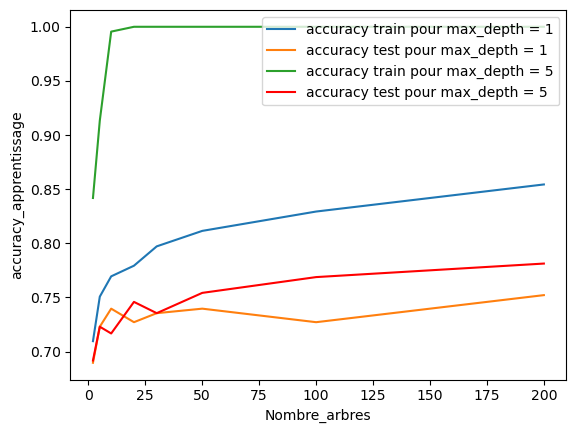

In [98]:
fig, ax = plt.subplots()
sns.lineplot(x='Nombre_arbres', y='accuracy_apprentissage', data=df1, ax=ax, label='accuracy train pour max_depth = 1')
sns.lineplot(x='Nombre_arbres', y='accuracy_test', data=df1, ax=ax, label='accuracy test pour max_depth = 1')
sns.lineplot(x='Nombre_arbres', y='accuracy_apprentissage', data=df5, ax=ax, label='accuracy train pour max_depth = 5')
sns.lineplot(x='Nombre_arbres', y='accuracy_test', data=df5, ax=ax, color='r', label='accuracy test pour max_depth = 5')
plt.show()

### Compromis biais et variance

Le biais est l'erreur du modèle et la variance est à quelle point notre modèle "colle" aux données d'entrainement.
Une variance trop haute couplée à un biais très bas signifie généralement un sur-apprentissage et une mauvaise généralisation, il faut donc trouver un compromis entre les deux.

<img src="https://miro.medium.com/max/1400/1*XliJhpczDHXWNthqWAk07g.webp">

Au-delà d’un certain nombre d'arbres :
- plus d’améliorations notables.
- pas d’overfitting.

##### Adaboost se base sur le BOOSTING : toujours apprendre sur différentes versions des données. On dirige l’apprentissage en se focalisant sur les données mal classées à l’étape précédente.

#### Biais et variance.
En orientant l’apprentissage à chaque étape, boosting agit sur le biais ; en les combinant, il agit sur la variance.
Arbres profonds peu biaisés => la combinaison réduit la variance individuelle.

En fin d’apprentissage, le poids des exemples « difficiles » augmente et l’algorithme se concentre sur ces exemples.

=> augmentation de la marge (les exemples difficiles sont ceux dont la marge est la plus faible.

#### On peut mesurer l'importance des variables en récupérant leurs poids : les exemples les plus difficiles à classe augmente donc les poids les plus forts représentes les variables les plus importantes.

Le BOOSTING se fait sur des apprenants faibles (weak learner) qui sont des modèle qui fait juste un peu mieux que le hasard.
Le Boosting combine des weak learner de manière appropriée et permet de produire un ensemble performant (strong classifier),
nettement meilleur que chaque modèle pris individuellement.


In [11]:
import warnings
warnings.filterwarnings('ignore')

#on garde le modèle OPTIMAL
clf = DecisionTreeClassifier(max_depth = 5)
adaboost_clf = AdaBoostClassifier(base_estimator = clf, n_estimators=50) #selon le cours, une 100taine suffit

#on fit
t0 = time.time()
adaboost_clf.fit(X_train, ybin[X_train.index])
t1 = time.time()

#prédiction des labels pour les données d'apprentissage
y_pred_app = adaboost_clf.predict(X_train)

#prédiction des labels pour les données de test
y_pred_test = adaboost_clf.predict(X_test)

total = (t1-t0)/len(X_train)
print("Temps d'inférence", total)

#accuracy en apprentissage
print("Accuracy en apprentissage", metrics.accuracy_score(ybin[X_train.index], y_pred_app))
#accuracy en test
print("Accuracy en test", metrics.accuracy_score(ybin[X_test.index], y_pred_test))

features_importance = pd.DataFrame({"Feature" : X.columns, "Important Variables" : adaboost_clf.feature_importances_})
features_importance = features_importance.sort_values("Important Variables", ascending=False)
features_importance

Temps d'inférence 0.0002641788649708166
Accuracy en apprentissage 1.0
Accuracy en test 0.75625


,Feature,Important Variables
1,volatile acidity,0.127885
4,chlorides,0.120800
9,sulphates,0.099618
10,alcohol,0.099212
6,total sulfur dioxide,0.091011
7,density,0.090682
8,pH,0.088309
0,fixed acidity,0.080547
5,free sulfur dioxide,0.077808
2,citric acid,0.070415


### C. Classification multiclasse

##### 1. Créer une nouvelle variable quantitative ymulti discrète à 3 modalités : qualité basse (0), moyenne (1) ou élevée (2).

On se base sur les quartiles :
- Q1 => 25% à G, et 75% à D
- Q2 => 50% à G, et 50% à D
- Q3 => 75% à G, et 25% à D
- Q4 => dernière valeur

Ici, on va diviser en 3.

In [12]:
ymulti = y.apply(lambda x: 2 if x>=np.quantile(y, 2/3) else 1 if x>=np.quantile(y, 1/3) else 0)

##### 2. Déterminer les effectifs des différentes classes. Si nécessaire, équilibrer les données d’apprentissage par sous-échantillonnage ou augmentation de données (SMOTE). Dans la suite, on présentera les résultats obtenus avec et sans équilibrage.

In [13]:
ymulti.value_counts() #on remarque un déséquilibre des classes

2    855
1    681
0     63
Name: quality, dtype: int64

On va donc utiliser la librairie imbalanced-learn.

In [14]:
reechantillonnage = SMOTE()
X_train_equil, y_train_equil = reechantillonnage.fit_resample(X_train, ymulti[X_train.index])
y_train_equil.value_counts()

2    587
1    587
0    587
Name: quality, dtype: int64

### Partie 1
##### 3. Entraîner un réseau de neurones à une couche cachée pour effectuer cette tâche de classification, avec early stopping sur la base de validation. L’optimiser rapidement en prenant soin d’éviter l’over-fitting. Etudier les matrices de confusion des réseaux optimaux dans le cas des données déséquilibrées puis, équilibrées. Conclure.

Un réseau de neurones a une couche cachée est un MPL.

###### Pour nos données équilibrées :

In [15]:
#on normalise nos données
normalized_X_train = preprocessing.normalize(X_train)
normalized_X_train_equil = preprocessing.normalize(X_train_equil)
normalized_X_test = preprocessing.normalize(X_test)

#on encode nos données sur 1 bit
#https://rukshanpramoditha.medium.com/one-hot-encode-scalar-value-labels-for-deep-learning-models-4d4053f185c5
'''train_labels = to_categorical(y_train_equil)
test_labels = to_categorical(y_test)'''

'train_labels = to_categorical(y_train_equil)\ntest_labels = to_categorical(y_test)'

In [16]:
print(len(normalized_X_train))
print(len(normalized_X_train_equil))
print(len(normalized_X_test))

print(len(y_train))
print(len(y_train_equil))
print(len(y_test))

1119
1761
480
1119
1761
480


In [ ]:
'''# architecture : 1 couche d'entrée, 1 couche cachée, 1 couche de sortie
MLP = Sequential()
MLP.add(InputLayer(input_shape=(10,))) # input layer, 
MLP.add(Dense(64, activation='relu')) # hidden layer 1, 64 neurones
MLP.add(Dense(3, activation='softmax')) # output layer, 3 classes de sortie, softmax car multiclass classification problem

# summary
MLP.summary()

#MLP.compile(loss= 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#MLP.fit(normalized_X_train, train_labels, epochs=5, validation_data=(normalized_X_test, test_labels), verbose=1)'''

In [17]:
mlp_clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(100), early_stopping=True)
mlp_clf.out_activation_ = 'softmax'

t0 = time.time()
mlp_clf.fit(normalized_X_train_equil, y_train_equil)
t1 = time.time()

y_pred_app = mlp_clf.predict(normalized_X_train_equil)
y_pred_test = mlp_clf.predict(normalized_X_test)
total = (t1-t0)/len(normalized_X_train_equil)

print("Temps d'inférence", total)
print('Accuracy en apprentissage: {:.4f}'.format(accuracy_score(y_train_equil, y_pred_app)))
print('Accuracy en test: {:.4f}'.format(accuracy_score(ymulti[X_test.index], y_pred_test)))

Temps d'inférence 0.0004577834385487926
Accuracy en apprentissage: 0.6712
Accuracy en test: 0.5792


In [18]:
y_pred_test

array([1, 0, 0, 2, 0, 0, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 0, 1, 2, 1, 0, 0,
       0, 2, 0, 1, 0, 1, 2, 2, 1, 1, 1, 2, 1, 0, 2, 2, 2, 2, 1, 2, 2, 0,
       2, 2, 1, 0, 2, 2, 1, 2, 1, 2, 2, 1, 0, 2, 2, 2, 1, 1, 1, 1, 1, 2,
       2, 2, 1, 2, 2, 2, 1, 0, 0, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1,
       2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 0, 0, 2, 1, 2, 1, 2, 2, 0, 1, 0,
       1, 2, 0, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 0, 2, 2,
       1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 2,
       2, 1, 2, 2, 2, 2, 2, 1, 1, 0, 1, 1, 2, 2, 2, 2, 0, 2, 2, 2, 1, 0,
       1, 2, 1, 1, 2, 1, 1, 2, 2, 0, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 0, 0,
       0, 2, 1, 0, 2, 2, 2, 0, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       1, 2, 2, 2, 2, 2, 1, 2, 0, 2, 1, 1, 0, 2, 1, 0, 2, 2, 1, 2, 1, 2,
       1, 2, 1, 1, 0, 2, 0, 2, 2, 0, 1, 1, 1, 2, 1, 0, 2, 0, 1, 2, 2, 1,
       2, 2, 1, 2, 2, 0, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 0, 0, 2, 2, 1, 1,
       1, 1, 2, 2, 0, 0, 2, 1, 1, 0, 2, 0, 1, 0, 2,

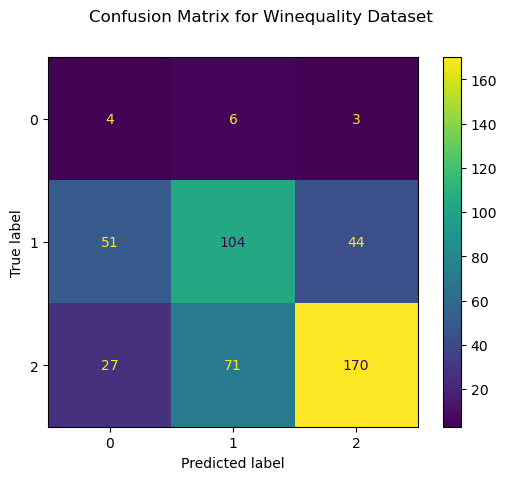

In [19]:
fig = plot_confusion_matrix(mlp_clf, normalized_X_test, ymulti[X_test.index], display_labels=mlp_clf.classes_)
fig.figure_.suptitle("Confusion Matrix for Winequality Dataset")
plt.show()

###### Pour nos données non-équilibrées :

In [21]:
mlp_clf_noneq = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(100), early_stopping=True)
mlp_clf_noneq.out_activation_ = 'softmax'

t0 = time.time()
mlp_clf_noneq.fit(normalized_X_train, ymulti[X_train.index])
t1 = time.time()

y_pred_app_noneq = mlp_clf_noneq.predict(normalized_X_train)
y_pred_test_noneq = mlp_clf_noneq.predict(normalized_X_test)
total = (t1-t0)/len(normalized_X_train)

print("Temps d'inférence", total)
print('Accuracy en apprentissage: {:.4f}'.format(accuracy_score(ymulti[X_train.index], y_pred_app_noneq)))
print('Accuracy en test: {:.4f}'.format(accuracy_score(ymulti[X_test.index], y_pred_test_noneq)))

Temps d'inférence 0.00040724237014184154
Accuracy en apprentissage: 0.7158
Accuracy en test: 0.6896


In [22]:
mlp_clf_noneq.classes_

array([0, 1, 2], dtype=int64)

In [23]:
res = mlp_clf_noneq.predict_proba(normalized_X_test)
res

array([[2.58719549e-02, 6.05248511e-01, 3.68879534e-01],
       [4.36152462e-02, 4.44312869e-01, 5.12071885e-01],
       [2.45230795e-01, 6.63211311e-01, 9.15578944e-02],
       ...,
       [2.46912717e-04, 1.23163206e-02, 9.87436767e-01],
       [1.24091564e-02, 6.19616651e-01, 3.67974193e-01],
       [2.12629216e-02, 1.76790409e-01, 8.01946669e-01]])

In [24]:
y_pred_test_noneq

array([1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1,
       2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2,
       2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1,
       2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 1, 1, 1,
       1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2,
       1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2,
       2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1,
       1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2,
       1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2,
       1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1,
       1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 0, 1, 1, 2,

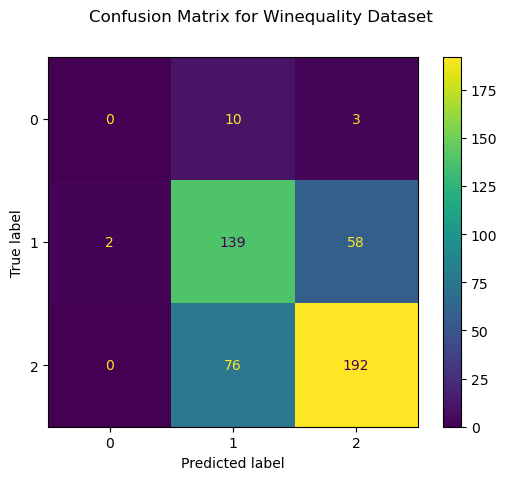

In [25]:
fig = plot_confusion_matrix(mlp_clf_noneq, normalized_X_test, ymulti[X_test.index], display_labels=mlp_clf_noneq.classes_)
fig.figure_.suptitle("Confusion Matrix for Winequality Dataset")
plt.show()

## On optimise un réseau de neurones avec un GridSearch sur nos hyperparamètres comme le nombre de neurones dans notre couche cachée, le solveur...

##### 4. Faire un bagging en utilisant comme classifieur de base le réseau de neurones.

-	Tracer la courbe accuracy en fonction de n_estimators, en apprentissage et en test.
-	Conclure sur le biais et la variance.

In [26]:
acc_train = []
acc_test = []
temps_inference = []
nbr_estimators = [1, 2, 5, 10, 50, 100, 200]

MLP_clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(100), early_stopping=True)
MLP_clf.out_activation_ = 'softmax'

for i in nbr_estimators:
    bagging_clf = BaggingClassifier(base_estimator=MLP_clf, n_estimators=i, verbose=False)
    
    t0 = time.time()
    bagging_clf.fit(normalized_X_train, ymulti[X_train.index])
    t1 = time.time()
    
    #predictions sur train et test
    predict_train = bagging_clf.predict(normalized_X_train)
    predict_test = bagging_clf.predict(normalized_X_test)
    
    acc_train.append(metrics.accuracy_score(ymulti[X_train.index], predict_train))
    acc_test.append(metrics.accuracy_score(ymulti[X_test.index], predict_test))
    temps_inference.append((t1-t0)/len(normalized_X_train))

df = pd.DataFrame()
df =df.assign(estimators=nbr_estimators)
df =df.assign(accuracy_train=acc_train)
df =df.assign(accuracy_test=acc_test)
df =df.assign(temps_inference=temps_inference) 
df

,estimators,accuracy_train,accuracy_test,temps_inference
0,1,0.714924,0.679167,0.000370
1,2,0.711349,0.685417,0.000739
2,5,0.712243,0.687500,0.001845
3,10,0.720286,0.687500,0.003916
4,50,0.722073,0.695833,0.018402
5,100,0.716711,0.691667,0.037326
6,200,0.719392,0.693750,0.075633


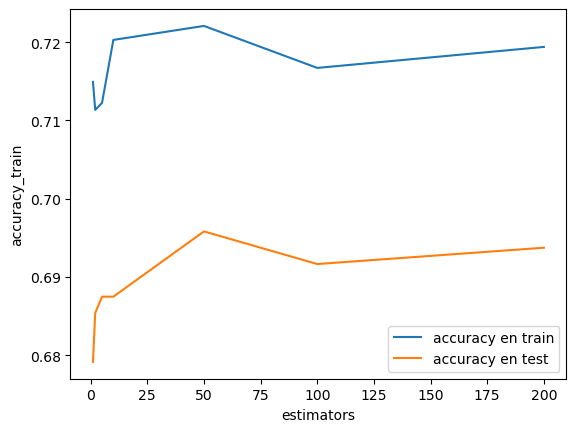

In [27]:
fig, ax = plt.subplots()
sns.lineplot(x='estimators', y='accuracy_train', data=df, ax=ax, label='accuracy en train')
sns.lineplot(x='estimators', y='accuracy_test', data=df, ax=ax, label='accuracy en test')
plt.show()

A la partie précédente et avec la classification biclasse, nous avions utilisé du BOOSTING avec des arbres de décisions.

Dans cette partie, nous faisons de la classification multiclasse avec du BAGGING : pour le bagging, nous avons besoin de modèles robustes de base, il n'est pas bon avec les apprenants faibles. C'est pour cela qu'ici, on préfère utiliser un MLP, plus robustes qu'un decision tree.

Principe de l'OUT OF BAG : 
Estimation de l’erreur OOB (out-of-bag) : mesure l’erreur directement durant l’apprentissage, sans avoir à passer par une validation croisée.

=> Sur-apprentissage (overfitting). Augmenter les modèles n’aboutit pas au sur-apprentissage. En pratique, une centaine suffit, mais on peut l’ajuster à l’étude.


=> Bagging peut s’appliquer à tout type de modèle.


=> Biais et variance. 
Biais bagging = biais du modèle de base. Le Bagging réduit avant tout la variance. Il faut donc que les modèles de base aient un biais faible.


https://machinelearningmastery.com/strong-learners-vs-weak-learners-for-ensemble-learning/


### Partie 2
##### 5. Entraîner une forêt aléatoire :

-	Tracer la courbe accuracy en fonction de n_estimators pour max_depth = None, en apprentissage et en test.
-	Faire une recherche aléatoire (random search) pour optimiser les paramètres max_depth et n_estimators. Choisir les paramètres optimaux et donner les performances en apprentissage et en test. Comparer avec les résultats obtenus précédemment (matrice de confusion sur les données déséquilibrées et équilibrées).
-	Afficher les variables par ordre d’importance. Retrouve-t-on les mêmes variables qu’en B.3 ?
-	Conclure sur le biais et la variance.

In [28]:
acc_train = []
acc_test = []
temps_inference = []
nb_arbres = [1, 2, 5, 10, 50, 100, 200, 500]

for i in nb_arbres:
    random_forest = RandomForestClassifier(n_estimators = i, criterion = "gini", max_depth = None)
    
    t0 = time.time()
    random_forest.fit(X_train, ymulti[X_train.index])
    t1 = time.time()
    
    pred_train = random_forest.predict(X_train)
    pred_test = random_forest.predict(X_test)
    acc_train.append(metrics.accuracy_score(ymulti[X_train.index], pred_train))
    acc_test.append(metrics.accuracy_score(ymulti[X_test.index], pred_test))
    temps_inference.append((t1-t0)/len(X_train))

df = pd.DataFrame()
df = df.assign(estimators=nb_arbres)
df = df.assign(accuracy_train=acc_train)
df = df.assign(accuracy_test=acc_test)
df = df.assign(temps_inference=temps_inference)
df

,estimators,accuracy_train,accuracy_test,temps_inference
0,1,0.870420,0.662500,0.000007
1,2,0.882038,0.622917,0.000007
2,5,0.981233,0.720833,0.000014
3,10,0.991063,0.727083,0.000029
4,50,1.000000,0.766667,0.000098
5,100,1.000000,0.779167,0.000200
6,200,1.000000,0.760417,0.000398
7,500,1.000000,0.762500,0.000986


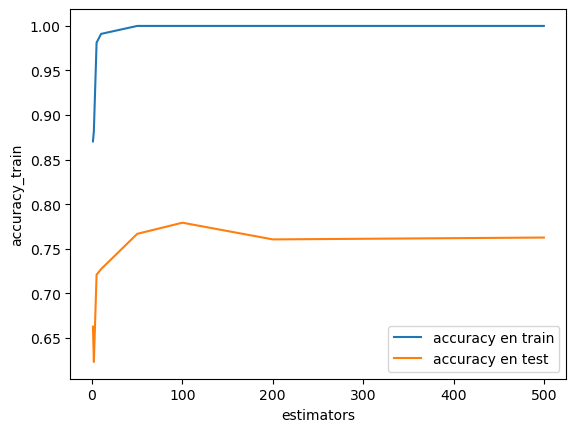

In [29]:
fig, ax = plt.subplots()
sns.lineplot(x='estimators', y='accuracy_train', data=df, ax=ax, label='accuracy en train')
sns.lineplot(x='estimators', y='accuracy_test', data=df, ax=ax, label='accuracy en test')
plt.show()

In [30]:
random_forest = RandomForestClassifier()

#on instancie les paramètres
parameters = {'max_depth': range(2, 100),
              'n_estimators': [1, 2, 5, 10, 50, 100, 200, 500],
              'criterion': ['gini', 'entropy']}

random_search = RandomizedSearchCV(estimator=random_forest, param_distributions = parameters, cv = 5)
random_search.fit(X_train, ymulti[X_train.index])

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", random_search.best_estimator_)
print("\n The best score across ALL searched params:\n", random_search.best_score_)
print("\n The best parameters across ALL searched params:\n", random_search.best_params_)

 Results from Random Search 

 The best estimator across ALL searched params:
 RandomForestClassifier(max_depth=51)

 The best score across ALL searched params:
 0.7783752402306213

 The best parameters across ALL searched params:
 {'n_estimators': 100, 'max_depth': 51, 'criterion': 'gini'}


In [32]:
#model optimal sur données non équilibrées
acc_train = []
acc_test = []
temps_inference = []

random_forest = RandomForestClassifier(n_estimators = 100, criterion = "gini", max_depth = 85)
    
t0 = time.time()
random_forest.fit(X_train, ymulti[X_train.index])
t1 = time.time()

total =((t1-t0)/len(X_train))
    
pred_train = random_forest.predict(X_train)
pred_test = random_forest.predict(X_test)

acc_train = metrics.accuracy_score(ymulti[X_train.index], pred_train)
acc_test= metrics.accuracy_score(ymulti[X_test.index], pred_test)

print('Accuracy en apprentissage: ', acc_train)
print('Accuracy en test: ', acc_test)
print("Temps d'inférence:", total)

Accuracy en apprentissage:  1.0
Accuracy en test:  0.7729166666666667
Temps d'inférence: 0.00021116109273602006


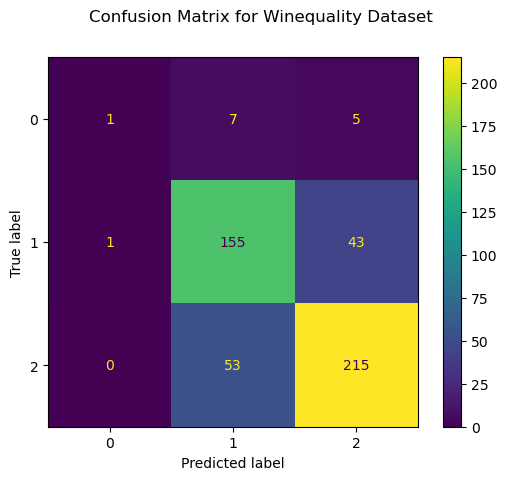

In [33]:
fig = plot_confusion_matrix(random_forest, X_test, ymulti[X_test.index], display_labels=random_forest.classes_)
fig.figure_.suptitle("Confusion Matrix for Winequality Dataset")
plt.show()

In [34]:
features_importance = pd.DataFrame({"Feature" : X.columns, "Important Variables" : random_forest.feature_importances_})
features_importance = features_importance.sort_values("Important Variables", ascending=False)
features_importance

,Feature,Important Variables
10,alcohol,0.173255
9,sulphates,0.114101
1,volatile acidity,0.113685
6,total sulfur dioxide,0.103415
7,density,0.094820
4,chlorides,0.078954
0,fixed acidity,0.075087
8,pH,0.068253
2,citric acid,0.061896
5,free sulfur dioxide,0.059116


In [39]:
#model optimal sur données non équilibrées
acc_train = []
acc_test = []
temps_inference = []

random_forest_eq = RandomForestClassifier(n_estimators = 100, criterion = "gini", max_depth = 85)
    
t0 = time.time()
random_forest_eq.fit(X_train_equil, y_train_equil)
t1 = time.time()

total =((t1-t0)/len(X_train))
    
pred_train = random_forest_eq.predict(X_train_equil)
pred_test = random_forest_eq.predict(X_test)

acc_train = metrics.accuracy_score(y_train_equil, pred_train)
acc_test= metrics.accuracy_score(ymulti[X_test.index], pred_test)

print('Accuracy en apprentissage: ', acc_train)
print('Accuracy en test: ', acc_test)
print("Temps d'inférence:", total)

Accuracy en apprentissage:  1.0
Accuracy en test:  0.7395833333333334
Temps d'inférence: 0.00030423126868417584


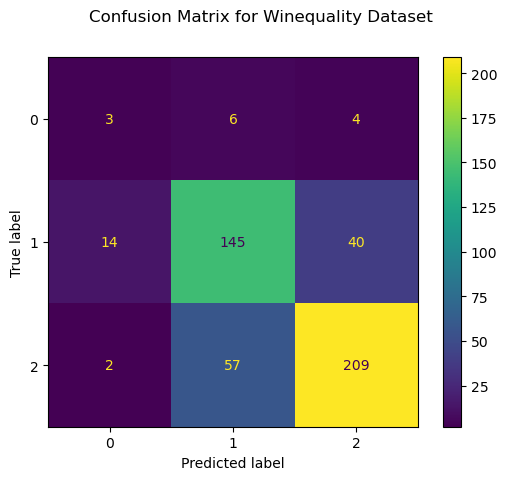

In [36]:
fig = plot_confusion_matrix(random_forest_eq, X_test, ymulti[X_test.index], display_labels=random_forest_eq.classes_)
fig.figure_.suptitle("Confusion Matrix for Winequality Dataset")
plt.show()

In [40]:
features_importance = pd.DataFrame({"Feature" : X.columns, "Important Variables" : random_forest_eq.feature_importances_})
features_importance = features_importance.sort_values("Important Variables", ascending=False)
features_importance

,Feature,Important Variables
9,sulphates,0.144207
6,total sulfur dioxide,0.139527
10,alcohol,0.126566
1,volatile acidity,0.112758
5,free sulfur dioxide,0.080424
8,pH,0.075744
7,density,0.070882
4,chlorides,0.067949
2,citric acid,0.064626
0,fixed acidity,0.062112


#### Random Forest :

Pour rendre le bagging (plus) efficace, il faut que les arbres :
1. Soient individuellement performants
2. De grande profondeur (biais faible)
3. Et surtout, très fortement différents les uns des autres

→ Utiliser RSM pour décorréler les échantillons 

:) Bonnes performances en prédiction

:) Paramétrage simple (B, max_depth)

:) Pas de problème d’overfitting (on peut augmenter B)

:) Evaluation de l’erreur intégrée (OOB)

:) Mesure de l’importance des variables

MAIS :

:( Problème si nombre de variables pertinentes très faibles, dans l’absolu et relativement au nombre total de variables

:( Explicabilité réduite




##### NB :
Scaling is done to Normalize data so that priority is not given to a particular feature. Role of Scaling is mostly important in algorithms that are distance based and require Euclidean Distance.

Random Forest is a tree-based model and hence does not require feature scaling.

This algorithm requires partitioning, even if you apply Normalization then also> the result would be the same.


#### Pour exporter le notebook en pdf :

- Ouvrir le prompt anaconda
- installer la bibliothèque : pip install nbconvert[webpdf]
- taper : jupyter nbconvert --to webpdf --allow-chromium-download TP_MADAD_NOUAR.ipynb

OU jupyter nbconvert --to webpdf --allow-chromium-download TP_MADAD_NOUAR.ipynb

OU jupyter nbconvert --to webpdf --no-input TP_MADAD_NOUAR.ipynb

OU jupyter nbconvert TP_MADAD_NOUAR.ipynb --to pdf